# Preprocessing

In [1]:
import os
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import median_abs_deviation as mad
%matplotlib inline

In [2]:
data_path = "data/"
check_path = "checkpoints/"

# os.makedirs(check_path)

os.chdir("../")
print(os.getcwd())

d:\JupyterWorkspace\02620


In [3]:
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)

## Data Preprocess Done!

In [4]:
adata = sc.read_h5ad(check_path + 'harmony.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 23873 × 2723
    obs: 'Sample', 'Title', 'Marker', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'batch'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'log1p', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

## k-Means Clustering

In [6]:
import numpy as np

def kmeans(data, initialCenters, k):
    objectives = []
    centers = np.array(initialCenters)
    n_features = data.shape[1]

    while True:
        # Assign points
        num_points = data.shape[0]
        num_centers = centers.shape[0]
        distances = np.zeros((num_points, num_centers))
        for i in range(num_points):
            distances[i] = np.sqrt(np.sum((data[i] - centers) ** 2, axis=1))
        closest_list = np.argmin(distances, axis=1)

        # Calculate objective function for this iteration
        objective = 0
        for i, point in enumerate(data):
            center_index = closest_list[i]
            center = centers[center_index]
            distance = 0

            for dim in range(len(point)):
                distance += (point[dim] - center[dim]) ** 2
            
            objective += distance
        objectives.append(objective)
        
        # Update the centers
        new_centers = np.zeros_like(centers)
        covariances = np.zeros((k, n_features, n_features))
        cluster_sizes = np.zeros(k, dtype=int)
        for i in range(k):
            points_cluster = data[closest_list == i]
            new_center = np.mean(points_cluster, axis=0)
            new_centers[i] = new_center
            if len(points_cluster) > 1:  # Avoid division by zero
                covariances[i] = np.cov(points_cluster, rowvar=False)
            cluster_sizes[i] = len(points_cluster)
        
        if np.allclose(centers, new_centers, atol=1e-4):
            break
        centers = new_centers
    
    return centers, covariances, cluster_sizes, closest_list, objectives


In [7]:
def kmeans_plusplus(X, k, seed):
    np.random.seed(seed)
    n_samples, _ = X.shape

    norms = np.linalg.norm(X, axis=1)
    first_centroid_index = np.argmax(norms)
    centroids = [X[first_centroid_index]]
    
    for _ in range(1, k):
        distances = np.array([min(np.sum((x - centroid)**2) for centroid in centroids) for x in X])

        probabilities = distances / distances.sum()
        cumulative_probabilities = np.cumsum(probabilities)
        r = np.random.rand()
        
        for i, p in enumerate(cumulative_probabilities):
            if r < p:
                centroids.append(X[i])
                break
    
    return np.array(centroids)

## Choose the appropriate seed

In [8]:
# Generate 10 random seeds
random_seeds = [np.random.randint(100000000) for _ in range(10)]
print(random_seeds)

[30528235, 66102621, 91182291, 80462453, 98736397, 93201548, 34303326, 42201111, 84695557, 49135795]


In [9]:
# Set PCA data as the input of K-means
pca_data = adata.obsm['X_pca_harmony']
objectives_dict = {}

for seed in random_seeds:
    print(seed)
    # Choose the initial centers
    initial_centers = kmeans_plusplus(pca_data, 10, seed)

    centers, covariances, sizes, closest_list, objectives = kmeans(pca_data, initial_centers, k=10)

    objectives_dict[seed] = objectives[-1]

min_objective_seed = min(objectives_dict, key=objectives_dict.get)

30528235
66102621
91182291
80462453
98736397
93201548
34303326
42201111
84695557
49135795


In [10]:
print(min_objective_seed)
print(objectives_dict[min_objective_seed])

93201548
6182960.652035195


In [11]:
# Previous result to replicate the poster result
min_objective_seed = 84631511

## Choose the appropriate k

In [12]:
# Set PCA data as the input of K-means
pca_data = adata.obsm['X_pca_harmony']
objectives_list = []

for i in range(3,30):
    print(i)
    # Choose the initial centers
    initial_centers = kmeans_plusplus(pca_data, i, min_objective_seed)

    centers, covariances, sizes, closest_list, objectives = kmeans(pca_data, initial_centers, k=i)

    objectives_list.append(objectives[-1])

    # Save the clustering result
    # adata.obs['kmeans_clusters'] = closest_list.astype(str)

    # Visualize the clustering result
    # neighborhood graph of cells
    # sc.pp.neighbors(adata)
    # compute UMAP
    # sc.tl.umap(adata)

    # sc.pl.umap(adata, color='kmeans_clusters', title='K-means Clustering Results')


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


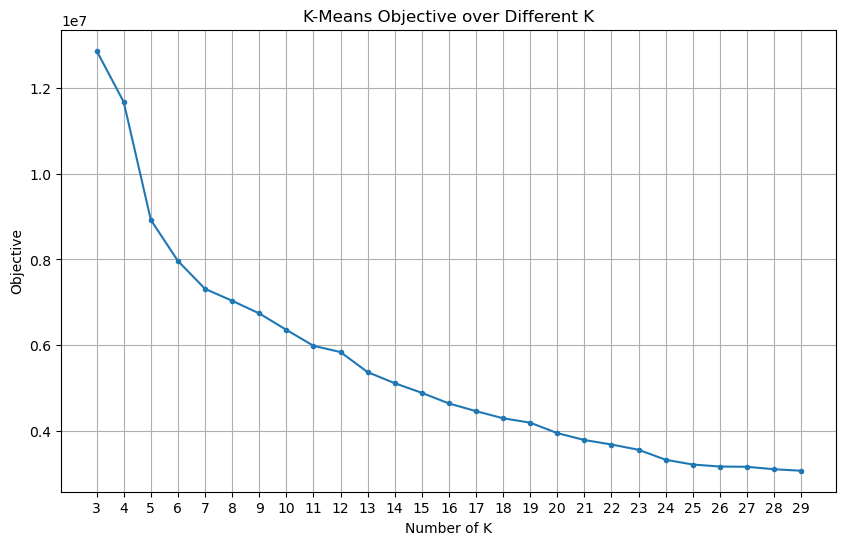

In [13]:
# Plot the change of K-means objective over different K
x_values = range(3, 30)

plt.figure(figsize=(10, 6))
plt.plot(x_values, objectives_list, marker='.')

plt.title('K-Means Objective over Different K')
plt.xlabel('Number of K')
plt.ylabel('Objective')

plt.xticks(range(3, 30))
plt.grid(True)
plt.show()

In [14]:
# Save the objective result
with open('objectives_list.txt', 'w') as file:
    for objective in objectives_list:
        file.write(f"{objective}\n")

## Plot the umap for best k

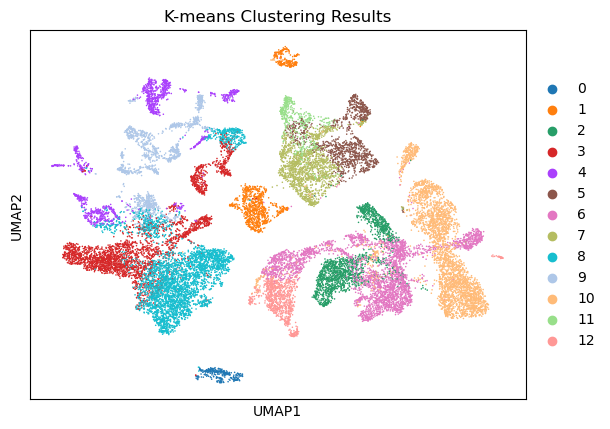

In [19]:
# Set PCA data as the input of K-means
pca_data = adata.obsm['X_pca_harmony']

# Choose the initial centers
initial_centers = kmeans_plusplus(pca_data, 13, 84631511)

centers, covariances, sizes, closest_list, objectives = kmeans(pca_data, initial_centers, k=13)

# Save the clustering result
adata.obs['kmeans_clusters'] = closest_list.astype(str)

# Visualize the clustering result
# neighborhood graph of cells
sc.pp.neighbors(adata)
# compute UMAP
sc.tl.umap(adata)

sc.pl.umap(adata, color='kmeans_clusters', title='K-means Clustering Results')

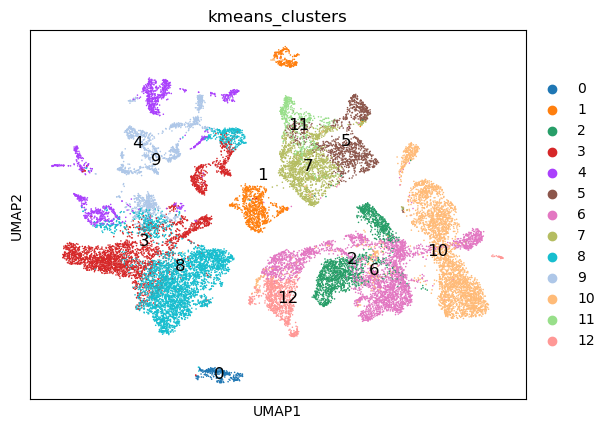

In [20]:
ax = sc.pl.umap(adata, color='kmeans_clusters', show=False)
cluster_centers = {}
for cluster in np.unique(adata.obs['kmeans_clusters']):
    mask = adata.obs['kmeans_clusters'] == cluster
    center = adata.obsm['X_umap'][mask].mean(axis=0)
    cluster_centers[cluster] = center
    ax.text(center[0], center[1], str(cluster), fontsize=12, ha='center', va='center', color='black')
plt.show()